In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from PIL import Image

# Set device and create output directory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create output directory for generated images
os.makedirs("generated_images", exist_ok=True)

Using device: cuda


In [4]:
# Hyperparameters
lr = 0.0002
batch_size = 64
image_size = 64
channels_img = 3  # RGB images
z_dim = 100
num_epochs = 10
features_gen = 64
features_disc = 64

In [ ]:
class YelpDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        # Filter out invalid images during initialization
        self.image_files = []
        for f in os.listdir(image_folder):
            if f.endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img_path = os.path.join(image_folder, f)
                    with Image.open(img_path) as img:
                        img.verify() 
                    self.image_files.append(f)
                except Exception as e:
                    print(f"Skipping corrupted image {f}: {str(e)}")
        print(f"Found {len(self.image_files)} valid images")
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        while True:
            try:
                img_path = os.path.join(self.image_folder, self.image_files[idx])
                image = Image.open(img_path).convert('RGB')
                if self.transform:
                    image = self.transform(image)
                return image
            except Exception as e:
                print(f"Error loading image {self.image_files[idx]}: {str(e)}")
                
                idx = (idx + 1) % len(self.image_files)

In [6]:
# Transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)]),
])

# Load Dataset
dataset = YelpDataset(image_folder='D:/DL/yelp_photos/photos', transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Skipping corrupted image -BIybLxzoFt2d2zbYRcfHA.jpg: cannot identify image file 'D:\\DL\\yelp_photos\\photos\\-BIybLxzoFt2d2zbYRcfHA.jpg'
Skipping corrupted image -NGY_19QK2zq913HdiYc5A.jpg: cannot identify image file 'D:\\DL\\yelp_photos\\photos\\-NGY_19QK2zq913HdiYc5A.jpg'
Skipping corrupted image -YAvSvGUs2ugiJUvIRO6Jw.jpg: cannot identify image file 'D:\\DL\\yelp_photos\\photos\\-YAvSvGUs2ugiJUvIRO6Jw.jpg'
Skipping corrupted image -ZkmgGLJ7AJTjy96nocMNw.jpg: cannot identify image file 'D:\\DL\\yelp_photos\\photos\\-ZkmgGLJ7AJTjy96nocMNw.jpg'
Skipping corrupted image 0fac-NlXqfBO2pWRkmM9aw.jpg: cannot identify image file 'D:\\DL\\yelp_photos\\photos\\0fac-NlXqfBO2pWRkmM9aw.jpg'
Skipping corrupted image 0TpeNZPs3Gu8s30KVXudcg.jpg: cannot identify image file 'D:\\DL\\yelp_photos\\photos\\0TpeNZPs3Gu8s30KVXudcg.jpg'
Skipping corrupted image 1MOGQBWogR8oJr1WgERi9g.jpg: cannot identify image file 'D:\\DL\\yelp_photos\\photos\\1MOGQBWogR8oJr1WgERi9g.jpg'
Skipping corrupted image 1wd_eyhMr

In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),  # 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # 32x32
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(), 
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )

    def forward(self, x):
        return self.gen(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [8]:
# Initialize networks
gen = Generator(z_dim, channels_img, features_gen).to(device)
disc = Discriminator(channels_img, features_disc).to(device)

# Optimizers
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

In [ ]:
# Training
print("Starting Training...")
for epoch in range(num_epochs):
    for batch_idx, real in enumerate(loader):
        real = real.to(device)
        batch_size = real.shape[0]
        
        # Train Discriminator
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = gen(noise)
        
        # Real images
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        
        # Fake images
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        
        # Total discriminator loss
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()
        
        # Train Generator
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        # Print losses oc
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch [{batch_idx}/{len(loader)}] "
                f"Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}"
            )

print("Training finished!")

# Generate images after training is complete
print("Generating images...")
gen.eval()  # Set generator to evaluation mode
with torch.no_grad():
    for i in range(5):  # Generate 5 different sets of images
        noise = torch.randn(16, z_dim, 1, 1).to(device)  
        fake = gen(noise)
        save_image(fake, f"generated_images/final_generated_set_{i+1}.png", normalize=True, nrow=4)
print("Image generation completed!")

Starting Training...
Epoch [0/10] Batch [0/3125] Loss D: 0.7464, Loss G: 2.8194
Epoch [0/10] Batch [100/3125] Loss D: 0.3341, Loss G: 2.2175
Epoch [0/10] Batch [200/3125] Loss D: 0.4636, Loss G: 2.1773
Epoch [0/10] Batch [300/3125] Loss D: 0.3672, Loss G: 1.8390
Epoch [0/10] Batch [400/3125] Loss D: 0.8352, Loss G: 1.7550
Epoch [0/10] Batch [500/3125] Loss D: 0.3667, Loss G: 2.9471
Epoch [0/10] Batch [600/3125] Loss D: 0.3786, Loss G: 2.4819
Epoch [0/10] Batch [700/3125] Loss D: 0.2573, Loss G: 4.0696
Epoch [0/10] Batch [800/3125] Loss D: 0.3679, Loss G: 3.1773
Epoch [0/10] Batch [900/3125] Loss D: 0.5362, Loss G: 3.5531
Epoch [0/10] Batch [1000/3125] Loss D: 0.6074, Loss G: 3.0312
Epoch [0/10] Batch [1100/3125] Loss D: 0.6991, Loss G: 6.5397
Epoch [0/10] Batch [1200/3125] Loss D: 0.5891, Loss G: 4.9109
Epoch [0/10] Batch [1300/3125] Loss D: 0.2648, Loss G: 4.2834
Epoch [0/10] Batch [1400/3125] Loss D: 0.3984, Loss G: 3.2262
Epoch [0/10] Batch [1500/3125] Loss D: 0.2624, Loss G: 2.6785

In [15]:
import torchvision.utils as vutils

def show_all_generated_images(fake):
    grid = vutils.make_grid(fake, nrow=int(fake.shape[0] ** 0.5), padding=2, normalize=True)
    vutils.save_image(grid, 'generated_images.png')

show_all_generated_images(fake)

In [17]:
import torchvision.utils as vutils
from IPython.display import Image

def show_all_generated_images(fake):
    grid = vutils.make_grid(fake, nrow=int(fake.shape[0] ** 0.5), padding=2, normalize=True)
    vutils.save_image(grid, 'generated_images.png')
    Image(filename='generated_images.png')

show_all_generated_images(fake)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9424577..0.9466188].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96196..0.97425586].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9982295..0.92677516].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9734646..0.99407023].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9895823..0.94841456].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8367678..0.9456598].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9998

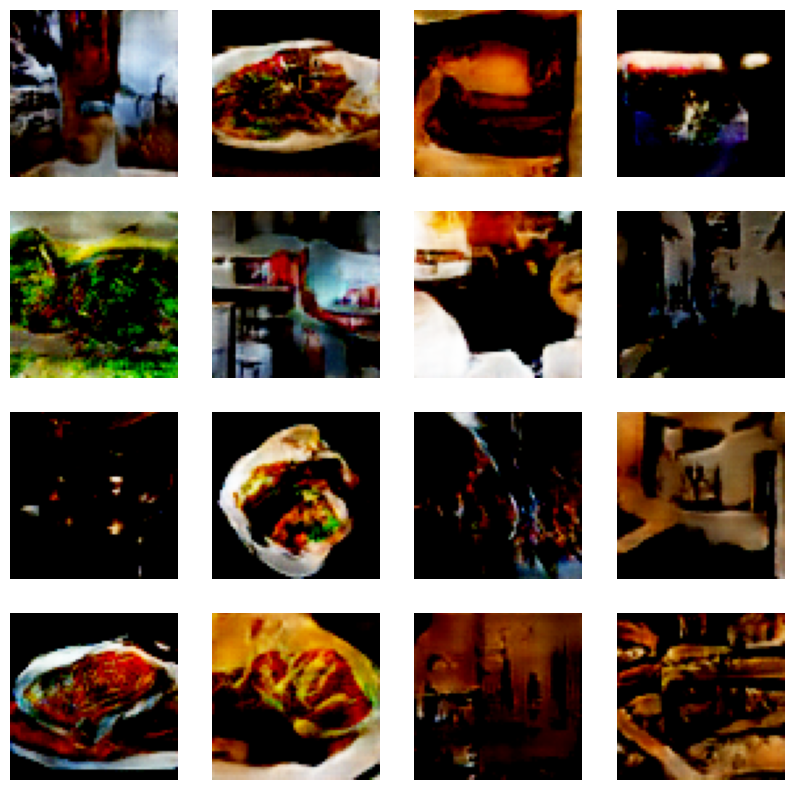

In [23]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
%matplotlib inline

def show_all_generated_images(fake):
    num_images = fake.shape[0]
    cols = int(num_images ** 0.5)
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i in range(fake.shape[0]):
        ax = axes[i // cols, i % cols]
        ax.imshow(fake[i].cpu().permute(1, 2, 0).numpy())
        ax.axis('off')
    plt.show()

show_all_generated_images(fake)

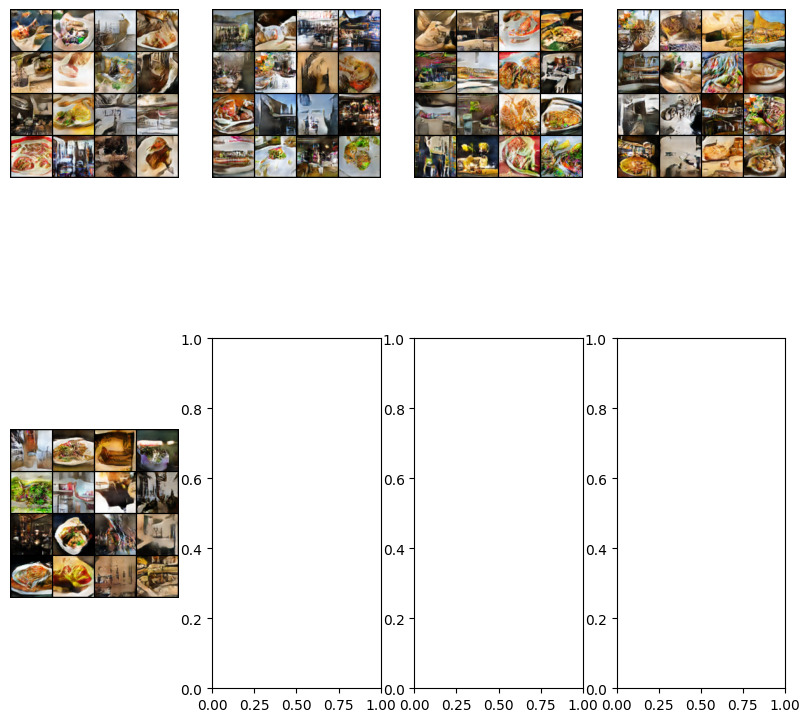

In [26]:
import matplotlib.pyplot as plt
import os
%matplotlib inline

def show_all_generated_images():
    folder_path = 'D:\\DL\\yelp_photos\\generated_images'
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    num_images = len(image_files)
    cols = 4
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, image_file in enumerate(image_files):
        ax = axes[i // cols, i % cols]
        ax.imshow(plt.imread(os.path.join(folder_path, image_file)))
        ax.axis('off')
    plt.show()

show_all_generated_images()

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3
from torch.nn.functional import adaptive_avg_pool2d
import numpy as np
from scipy.linalg import sqrtm
from torch.utils.data import DataLoader, Dataset, Subset
import random
from PIL import Image, UnidentifiedImageError
import os
import gc
import warnings
warnings.filterwarnings('ignore')

def setup_device():
    device = torch.device("cpu")
    print("Using device: cpu")
    return device

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"Found {len(self.images)} images in {root_dir}")
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx])
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image
        except (IOError, SyntaxError, UnidentifiedImageError) as e:
            print(f"Skipping corrupted image {self.images[idx]}")
            if self.transform:
                return torch.zeros((3, 299, 299))
            return Image.new('RGB', (299, 299), 'black')

def get_valid_subset(dataset, size):
    """Get a valid subset of images, skipping corrupted ones"""
    valid_indices = []
    all_indices = list(range(len(dataset)))
    random.shuffle(all_indices)
    
    for idx in all_indices:
        try:
            img = dataset[idx]
            if isinstance(img, torch.Tensor) and not torch.all(img == 0):  
                valid_indices.append(idx)
                if len(valid_indices) >= size:
                    break
        except Exception:
            continue
    
    print(f"Found {len(valid_indices)} valid images out of {size} requested")
    return Subset(dataset, valid_indices)

def inception_score(imgs, device, batch_size=1, splits=1):
    print(f"Calculating Inception Score for {len(imgs)} images")
    N = len(imgs)
    assert batch_size > 0
    assert N >= batch_size

    dataloader = DataLoader(imgs, batch_size=batch_size)
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()
    print("Inception model loaded and moved to", device)

    preds = []
    for batch in dataloader:
        if not isinstance(batch, torch.Tensor):
            batch = batch.to(device)
        batch = batch.unsqueeze(0) if batch.dim() == 3 else batch
        with torch.no_grad():
            pred = inception_model(batch)
            pred = torch.nn.functional.softmax(pred, dim=1)
            preds.append(pred.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    
    # Calculate mean KL divergence
    split_scores = []
    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

def calculate_fid(real_dataset, fake_dataset, device):
    print("Calculating FID...")
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    def get_features(dataset):
        all_features = []
        dataloader = DataLoader(dataset, batch_size=1)
        with torch.no_grad():
            for batch in dataloader:
                if not isinstance(batch, torch.Tensor):
                    batch = batch.to(device)
                batch = batch.unsqueeze(0) if batch.dim() == 3 else batch
                features = inception_model(batch)
                all_features.append(features.cpu().numpy())
        return np.concatenate(all_features, axis=0)

    real_features = get_features(real_dataset)
    fake_features = get_features(fake_dataset)

    # Calculate mean and covariance
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    # Calculate FID
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def main():
    device = setup_device()
    
    # Set up transforms
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])

    print("Loading datasets...")
    fake_dataset = CustomImageDataset('generated_images', transform=transform)
    real_dataset = CustomImageDataset('photos', transform=transform)

    # Get valid subsets
    fake_subset = get_valid_subset(fake_dataset, len(fake_dataset))  
    real_subset = get_valid_subset(real_dataset, 1000)  

    print(f"Number of valid generated images: {len(fake_subset)}")
    print(f"Number of valid real images (subset): {len(real_subset)}")

    results = {}
    
    try:
        print("\nCalculating Inception Score...")
        is_mean, is_std = inception_score(fake_subset, device)
        print(f'Inception Score: {is_mean:.2f} ± {is_std:.2f}')
        results['inception_score'] = (is_mean, is_std)
    except Exception as e:
        print(f"Error calculating Inception Score: {str(e)}")
        results['inception_score'] = None

    try:
        print("\nCalculating FID Score...")
        fid_value = calculate_fid(real_subset, fake_subset, device)
        print(f'FID Score: {fid_value:.2f}')
        results['fid_score'] = fid_value
    except Exception as e:
        print(f"Error calculating FID Score: {str(e)}")
        results['fid_score'] = None

    print("\nSaving results...")
    with open('evaluation_results.txt', 'w') as f:
        f.write("Evaluation Results\n")
        f.write("=================\n\n")
        f.write(f"Device used: {device}\n")
        f.write(f"\nNumber of valid generated images: {len(fake_subset)}\n")
        f.write(f"Number of valid real images (subset): {len(real_subset)}\n")
        if results['inception_score']:
            f.write(f"\nInception Score: {results['inception_score'][0]:.2f} ± {results['inception_score'][1]:.2f}\n")
        if results['fid_score'] is not None:
            f.write(f"FID Score: {results['fid_score']:.2f}\n")

    print("\nResults have been saved to 'evaluation_results.txt'")

if __name__ == "__main__":
    try:
        main()
    finally:
        gc.collect()

Using device: cpu
Loading datasets...
Found 5 images in generated_images
Found 200098 images in photos
Found 5 valid images out of 5 requested
Found 1000 valid images out of 1000 requested
Number of valid generated images: 5
Number of valid real images (subset): 1000

Calculating Inception Score...
Calculating Inception Score for 5 images
Inception model loaded and moved to cpu
Inception Score: 1.28 ± 0.00

Calculating FID Score...
Calculating FID...
FID Score: 2276.22

Saving results...

Results have been saved to 'evaluation_results.txt'
